#### List 3, Algorithms and Data Structures - Lab, WUST-F13
#### Mateusz Machaj, 04.11.2021


In [4]:
import re
from pandas import DataFrame as df

---

# Task 1
#### *Restricted number of multiplications in the formula.*

---

### MATHEMAICAL ANALYSIS AND THE IDEA EXPLANATION

For the function

$$P(n, k) = \sum_{i=0}^k {n\choose i} p^i (1-p)^{n-i}$$

we will try to find an algorithm which uses at most $3k+\log n$ multiplications.

At first, we can notice some identity:

$${n \choose k} = \frac{\prod_{i=1}^k{n-i+1}}{\prod_{i=1}^k i}=\prod_{i=1}^k \frac{n-i+1}{i}.$$

Therefore, for $i\geq 0$, each element of the sum is a member of the recursive sequence:

$$
\left\{
    \begin{array}\\
        a_0 = (1-p)^n\\
        a_i = a_{i-1} \cdot \frac{n-i+1}{i}\cdot Q, & i\in \mathbb{N} \wedge i\geq1 
    \end{array}
\right.,
$$

$$\textrm{where}\quad Q=\frac{p}{1-p}=\textrm{const}.$$

Our formula has then a folowing shape:

$$P(n, k) = \sum_{i=0}^k a_i = a_0 + a_1 + \sum_{i=2}^k a_i.$$

So that, to find the sum we should do the following steps:

* find $(1-p)^n$ using the proper exponentiation algorithm - __2log(n) multiplications__,
* calculate $Q = \frac{p}{1-p}$ - __1 multiplication (division)__,
* for each next element multiplicate the previous sequence member by $n-i+1$, by $Q$, and divide it by $i$ (for the proper $i$) - __3 multiplications/divisions per iteration__;

* in addition to that, for $i=1$ certainly $\frac{n-i+1}{i}=n$, so in this iteration we can simply reduce the number of multiplications __form 3 to 2__.

All things considered, after having $(1-p)^n$ calculated, we should perform $1 + 2 + 3 \cdot (k-1) = 3k$ multiplications to get the values of the sum elements - because we have got $k$ iterations in the formula.

Hence, the maximal total number of multiplications is represented by the function

$$M(n, k) = 2\log n + 3k.$$

(Algorithms of $O(\log n)$ class in reality do $2\cdot \log n$ multiplications and we can do nothing about it. I hope it is enough for the task being scored.)

### ALGORITHM CODING

We can start with creating an exponentiation function, handling the positive integer powers:

In [5]:
def power(base: float, expon: int) -> float:
    """
    Raise an integer to a natural power using bitwise log(n) algorithm.

    Args:
        base (int/float): Base of the exponential function.
        expon (int): Power of the function.

    Raises:
        TypeError: Only integer power is allowed.
        ValueError: Only positive power is allowed.

    Returns:
        float: Result of the exponentiation.
    """
    if not isinstance(expon, int):
        raise TypeError("Wrong argument type. Exponent should be an integer.")
    if expon < 0:
        raise ValueError("Invalid exponent value. Exponent should be positive.")

    if expon == 0:
        return 1

    res = 1
    while expon > 0:
        if expon & 1:  # bitwise reminder test
            res *= base
        base *= base
        expon >>= 1  # shift right to see what is the next bit
    return res

A power can be represented as $m = d_0\cdot2^0 + d_1\cdot2^1 + d_2\cdot2^2 + \ldots$, where $d_i\in \{ 0, 1\}$, depending on the numbers in the bitwise representation. Thus, $a^m = a^{d_0 2^0}\cdot a^{d_1 2^1}\cdot d_2 a^{d_2 2^3}\cdot\ldots.$ In each iteration we prepare new $a^{2^i}=a^{2^{i-1}}\cdot a^{2^{i-1}}$, and if the power's current bit is $1$, we multiply the whole result variable by it. 

Then, let us create the right function for calculating the probability - using the algorithm described before:

In [6]:
def probab(n: int, k: int, p: float) -> float:
    """Find the probability of at most `k` successes in `n` attempts, having given the probability of a single success.
    Use the algorithm restricting the number of multiplications.

    Args:
        n (int): Total number of attempts.
        k (int): Maximal number of successes.
        p (float): Single success probability.

    Raises:
        ValueError: Probability must be between 0 and 1.

    Returns:
        float: Total probability.
    """
    if p > 1 or p < 0:
        raise ValueError
    Q = p / (1 - p)  # constant coefficient
    res = 0

    curr_memb = power(1 - p, n)  # first element - `i=0`
    res += curr_memb
    curr_memb *= n * Q  # second element - `i=1`
    res += curr_memb

    for i in range(2, k + 1):  # the rest of the elements
        curr_memb *= (n - i + 1) / i * Q
        res += curr_memb

    return res

### PRESENTATION

Probability of at most $4$ successes during $10$ attempts, when the probability of single success is $\frac{1}{3}$:

In [24]:
probab(n=10, k=4, p=1/3)

0.7868719199309052

Hence, $P_{\frac{1}{3}}(10, 4) \approx 0.7869 .$

---

# Task 2
#### Evaluating a polynomial.

---

### MATHEMAICAL ANALYSIS AND THE IDEA EXPLANATION

As having a $a_0 + a_1 x + a_2 x^2 + \ldots + a_n x^n$ polynomial, we can write it also as

$$a_0 + x\cdot(a_1 + x\cdot(a_2 + x\cdot (\cdots x\cdot a_n))).$$

This way of thinking allows us to perform __only $n$ multiplications__ and the rest of operations is addition.

Therefore, given the list of $a_i,\, i\in\{1, 2, \ldots, n\}$ and a specific $x$, we have to start from the most nested parenthesis and proceed to the outside. We mulitiply $x$ by $a_n$ and sum the result with $a_{n-1}$. Then, do the same instructions until the list is over.

### ALGORITHM CODING

We try to code exactly the same thing that is decsribed above:

In [17]:
def polyn(a_coeff: list, x: float) -> float:
    """For a given `x` evaluate the polynomial using only `n` multiplications.
    (`n` is a degree of the polynomial.)

    Args:
        a_coeff (list[float]): List of polynomial coeffitients.
        x (int/float): Polynomial variable value.

    Raises:
        TypeError: `x` is expected to be a number.
        TypeError: `a_coeff` is expected to be a list.
        ValueError: List `a_coeff` cannot be empty.
        TypeError: Coeffitients are expected to be numbers.

    Returns:
        int/float: Value of the polynomial for the given `x`.
    """
    if type(x) not in {int, float}:
        raise TypeError("Wrong argument type. `x` is expected to be a number.")
    if not isinstance(a_coeff, list):
        raise TypeError(
            "Wrong argument type. `a_coeff` is expected to be a list of coefficients.")
    if a_coeff == []:
        raise ValueError("List of coefficients cannot be empty.")
    if not all(type(a) in {int, float} for a in a_coeff):
        raise TypeError("Coeffitients are expected to be numbers.")

    # the initial `result` is `a_n`, then we iterate begining from `a_(n-1)`
    res = a_coeff[-1]
    for a in a_coeff[-2::-1]:
        res = x * res + a
    return res

### PRESENTATION

* Dla $x=0$, mamy $1+x=1.$

In [20]:
polyn([1, 1], 0)

1

* Dla $x=21$, mamy $1+3x+2x^2+7x^3+6x^4=1232659.$

In [21]:
polyn([1, 3 , 2 , 7 , 6], 21)

1232659

* Dla $x=42$, mamy $1+3x^5=392073697.$

In [23]:
polyn([1, 0 , 0 , 0 , 0, 3], 42)

392073697

---

# Task 3
#### Counting letters without the conditional statement.

---

### ANALYSIS AND THE IDEA EXPLANATION

The main structure that will be used in this algorithm is a dictionary. Iterating over all the characters in the string we will try to increment the _counter value_ for a proper key in dictionary by 1. If the key does not exist, the error is thrown and we handle it by creating this specific key and assigning to it a value of 1 (becouse of the first repetition).

That means __we do not have to use _"if"_ instruction.__ 

Before getting to work we can clean the text up a little. Thereupon, the following steps are done:
* changing the uppercase letters to the lowercase - to consider them as the same symbol,
* getting rid of all the punctuation and white symbols - only alphanumeric symbols will be important.

_(Apparently, the algorithm can cound alphanumeric symbols. Now we choose the "garbage free" version.)_

### ALGORITHM CODING

The main function which prepares the data:

In [8]:
def char_count(text: str) -> dict:
    """Count the occurences of each character in the given text (excluding the puncuation and white characters).

    Args:
        text (str): Text to compare the occurences.

    Raises:
        TypeError: Text on input must be a string.

    Returns:
        dict: Dictionary where number of occurences is assigned to each symbol encountered.
    """
    if not isinstance(text, str):
        raise TypeError("Argumet is expected to be a string.")

    # treat upper and lowercase letters as the same
    text = re.sub('([A-Z]{1})', r'\1', text).lower()
    # do not consider non alphanumeric symbols
    text = re.sub('[\W]', '', text)

    db = dict()
    for char in text:
        try:
            db[char] += 1
        except:
            db[char] = 1
    return db


We can also add a visualisation function, which will present a bar graph of sorted values for each character in the text:

In [9]:
def char_graph(data: dict):
    """Plot a bar graph of the character occurences, sorting them in a descending way.

    Args:
        data (dict): Dictionary of characters and their occurrences.
    """
    frame = df({'char': data.keys(), 'number': data.values()})
    frame.set_index('char', inplace=True)
    frame.sort_values('number', inplace=True, ascending=False)
    frame.plot.bar(rot=0, title="Character occurrence comparison.")

### PRESENTATION

#### _INPUT:_

In [10]:
text = '''Litwo! Ojczyzno maja! Ty jesteś jak zdrowie,
Ile cię trzeba cenić, ten tylko się dowie,
Kto cię stracił. Dziś piękność twą w całej ozdobie
Widzę i opisuję, bo tęsknię po tobie"
Panno święta, co Jasnej bronisz Częstochowy
I w Ostrej świecisz Bramie! Ty, co gród zamkowy
Nowogródzki ochraniasz z jego wiernym ludem!
Jak mnie dziecko do zdrowia powróciłaś cudem,
(Gdy od płaczącej matki pod Twoją opiekę
Ofiarowany, martwą podniosłem powiekę
I zaraz mogłem pieszo do Twych świątyń progu
Iść za wrócone życie podziękować Bogu),
Tak nas powrócisz cudem na Ojczyzny łono.
Tymczasem przenoś moją duszę utęsknioną
Do tych pagórków leśnych, do tych łąk zielonych,
Szeroko nad błękitnym Niemnem rozciągnionych;
Do tych pól malowanych zbożem rozmaitem,
Wyzłacanych pszenicą, posrebrzanych żytem;
Gdzie bursztynowy świerzop, gryka jak śnieg biała,
Gdzie panieńskim rumieńcem dzięcielina pała,
A wszystko przepasane jakby wstęgą, miedzą
Zieloną, na niej z rzadka ciche grusze siedzą.'''

Let's take a glimpse at the raw generated dictionary. It obviously has regard also to polish characters.

In [11]:
data = char_count(text)

In [12]:
print(data)

{'l': 10, 'i': 66, 't': 32, 'w': 31, 'o': 70, 'j': 18, 'c': 40, 'z': 49, 'y': 32, 'n': 43, 'm': 28, 'a': 52, 'e': 58, 's': 29, 'ś': 12, 'k': 25, 'd': 30, 'r': 32, 'ę': 18, 'b': 13, 'ć': 4, 'ł': 12, 'p': 24, 'ą': 14, 'u': 11, 'h': 13, 'g': 15, 'ó': 8, 'f': 1, 'ń': 3, 'ż': 3}


Finally, we may illustrate the findings:

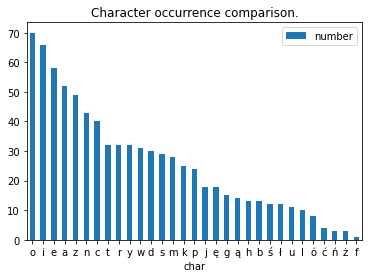

In [13]:
char_graph(data)